In [1]:
import os
import glob
import random
import numpy as np

In [2]:
ROOT = os.path.join(os.getcwd(),'img')
img_folders = {
    'clown':os.path.join(ROOT,'clown'),
    'reef':os.path.join(ROOT,'reef')
}

In [3]:
RESULT = {
    0:'Clown Fish',
    1:'No clown fish'
}

# All in one loading and preprocessing

In [4]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [5]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]


train_transforms = transforms.Compose([transforms.Resize(size=64),
                                       transforms.CenterCrop(size=64),
                                       transforms.ToTensor(),
                                       ])

# change root to valid dir in your system, see ImageFolder documentation for more info
dataset = datasets.ImageFolder(root=ROOT,
                                    transform=train_transforms)

In [6]:
N = round(len(dataset)*0.7)
indices = list(range(len(dataset)))
train_ids = list(np.random.choice(indices,size=N,replace=False))
test_ids = list(set(indices) - set(train_ids))

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_ids)
test_sampler = SubsetRandomSampler(test_ids)

In [8]:
trainset = DataLoader(dataset=dataset,
                      batch_size=8,
                      #shuffle=True,
                      sampler = train_sampler
                      #collate_fn=my_collate # use custom collate function here
                      )
testset = DataLoader(dataset=dataset,
                      batch_size=4,
                        #shuffle=True,
                      sampler = test_sampler
                      )

trainiter = iter(trainset)
imgs, labels = trainiter.next()

Clown Fish


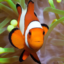

In [9]:
example = imgs[0]
print(RESULT[labels[0].item()])
transforms.ToPILImage()(example)

# Training part

# Define network

In [10]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [11]:
def abs_size(x):
    S = x.size()
    result = 1
    for s in S[1:]:
        result *= s
    return result

In [12]:
class FishNet(nn.Module):
    def __init__(self,number_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.apool = nn.AdaptiveAvgPool2d(8)
        self.fc1 = nn.Linear(8 * 8 * 16, 128)     # 8x8 square output, 16 layers
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, number_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.apool(x)
        x = x.view(-1, abs_size(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


mynet = FishNet(2)
mynet

FishNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (apool): AdaptiveAvgPool2d(output_size=8)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

## Optimizer

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.01, momentum=0.8)

In [14]:
def adjust_learning_rate(optimizer, decay_factor=0.1):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_factor
        
    return optimizer

In [15]:
def is_stagnant(L,n=10,eps=1e-2):
    M1 = np.mean(L[-2*n:-n])
    M2 = np.mean(L[-n:])
    D = (M1-M2)/(M1+M2)
    return abs(D)<eps

In [16]:
# TO DO
#optim.lr_scheduler.

## Train step

In [17]:
LOSSES = []
EPOCH_ELAPSED = 0

In [28]:
print_batch = 4
N_epoch = 200
epochs_since_last_decay = 0
decay = 5

for epoch in range(1,N_epoch+1):  # loop over the dataset multiple times
    
    print('\n','---------- Epoch {:03d} ----------'.format(EPOCH_ELAPSED))
    running_loss = 0.0
    
    for i, data in enumerate(trainset, 1):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mynet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() #loss.data[0] deprecated in newer versions of PyTorch
        if i % print_batch == 0:    # print every few mini-batches
            LOSSES.append(running_loss)
            print('     Batch {:02d} | Loss: {:.4f}'.format(i ,running_loss / print_batch))
            running_loss = 0.0
            
    # Decay LR when learning is stalling, for better convergence
    if epochs_since_last_decay>5 and is_stagnant(LOSSES,3):
        optimizer = adjust_learning_rate(optimizer,decay_factor=1.0/decay)
        epochs_since_last_decay = 0
        print('\n','='*10,'LR decayed by',decay,'='*10,'\n')
    
    # Some updating
    epochs_since_last_decay += 1
    EPOCH_ELAPSED += 1
            
print('Finished Training')


 ---------- Epoch 200 ----------
     Batch 04 | Loss: 0.0464
     Batch 08 | Loss: 0.0984
     Batch 12 | Loss: 0.1678
     Batch 16 | Loss: 0.5020
     Batch 20 | Loss: 0.3682
     Batch 24 | Loss: 0.4399
     Batch 28 | Loss: 0.2335
     Batch 32 | Loss: 0.3792
     Batch 36 | Loss: 0.4285

 ---------- Epoch 201 ----------
     Batch 04 | Loss: 0.2038
     Batch 08 | Loss: 0.3030
     Batch 12 | Loss: 0.1550
     Batch 16 | Loss: 0.1746
     Batch 20 | Loss: 0.0359
     Batch 24 | Loss: 0.6381
     Batch 28 | Loss: 0.4234
     Batch 32 | Loss: 0.2977
     Batch 36 | Loss: 0.3656

 ---------- Epoch 202 ----------
     Batch 04 | Loss: 0.1824
     Batch 08 | Loss: 0.2124
     Batch 12 | Loss: 0.1866
     Batch 16 | Loss: 0.1029
     Batch 20 | Loss: 0.1432
     Batch 24 | Loss: 0.3340
     Batch 28 | Loss: 0.2143
     Batch 32 | Loss: 0.2060
     Batch 36 | Loss: 0.2847

 ---------- Epoch 203 ----------
     Batch 04 | Loss: 0.0766
     Batch 08 | Loss: 0.2002
     Batch 12 | Loss: 0

     Batch 32 | Loss: 0.0061
     Batch 36 | Loss: 0.0019

 ---------- Epoch 228 ----------
     Batch 04 | Loss: 0.0051
     Batch 08 | Loss: 0.0015
     Batch 12 | Loss: 0.0006
     Batch 16 | Loss: 0.0013
     Batch 20 | Loss: 0.0028
     Batch 24 | Loss: 0.0015
     Batch 28 | Loss: 0.0020
     Batch 32 | Loss: 0.0037
     Batch 36 | Loss: 0.0012

 ---------- Epoch 229 ----------
     Batch 04 | Loss: 0.0039
     Batch 08 | Loss: 0.0030
     Batch 12 | Loss: 0.0006
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0015
     Batch 24 | Loss: 0.0014
     Batch 28 | Loss: 0.0009
     Batch 32 | Loss: 0.0005
     Batch 36 | Loss: 0.0010

 ---------- Epoch 230 ----------
     Batch 04 | Loss: 0.0011
     Batch 08 | Loss: 0.0008
     Batch 12 | Loss: 0.0011
     Batch 16 | Loss: 0.0007
     Batch 20 | Loss: 0.0007
     Batch 24 | Loss: 0.0024
     Batch 28 | Loss: 0.0021
     Batch 32 | Loss: 0.0005
     Batch 36 | Loss: 0.0001

 ---------- Epoch 231 ----------
     Batch 04 | Loss: 0

     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0002
     Batch 32 | Loss: 0.0001
     Batch 36 | Loss: 0.0003

 ---------- Epoch 256 ----------
     Batch 04 | Loss: 0.0004
     Batch 08 | Loss: 0.0006
     Batch 12 | Loss: 0.0001
     Batch 16 | Loss: 0.0002
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0000
     Batch 28 | Loss: 0.0000
     Batch 32 | Loss: 0.0004
     Batch 36 | Loss: 0.0002

 ---------- Epoch 257 ----------
     Batch 04 | Loss: 0.0000
     Batch 08 | Loss: 0.0006
     Batch 12 | Loss: 0.0002
     Batch 16 | Loss: 0.0004
     Batch 20 | Loss: 0.0002
     Batch 24 | Loss: 0.0003
     Batch 28 | Loss: 0.0000
     Batch 32 | Loss: 0.0002
     Batch 36 | Loss: 0.0001

 ---------- Epoch 258 ----------
     Batch 04 | Loss: 0.0000
     Batch 08 | Loss: 0.0001
     Batch 12 | Loss: 0.0001
     Batch 16 | Loss: 0.0005
     Batch 20 | Loss: 0.0003
     Batch 24 | Loss: 0.0003
     Batch 28 | Loss: 0.0002
     Batch 32 | Loss: 0.0004
     Batch 36 | Loss: 0.0001

     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0002
     Batch 24 | Loss: 0.0003
     Batch 28 | Loss: 0.0001
     Batch 32 | Loss: 0.0001
     Batch 36 | Loss: 0.0001

 ---------- Epoch 284 ----------
     Batch 04 | Loss: 0.0001
     Batch 08 | Loss: 0.0001
     Batch 12 | Loss: 0.0000
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0002
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0001
     Batch 32 | Loss: 0.0002
     Batch 36 | Loss: 0.0002

 ---------- Epoch 285 ----------
     Batch 04 | Loss: 0.0001
     Batch 08 | Loss: 0.0002
     Batch 12 | Loss: 0.0002
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0000
     Batch 32 | Loss: 0.0001
     Batch 36 | Loss: 0.0002

 ---------- Epoch 286 ----------
     Batch 04 | Loss: 0.0001
     Batch 08 | Loss: 0.0001
     Batch 12 | Loss: 0.0002
     Batch 16 | Loss: 0.0002
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0000
     Batch 28 | Loss: 0.0001

     Batch 08 | Loss: 0.0001
     Batch 12 | Loss: 0.0002
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0000
     Batch 32 | Loss: 0.0000
     Batch 36 | Loss: 0.0000

 ---------- Epoch 312 ----------
     Batch 04 | Loss: 0.0000
     Batch 08 | Loss: 0.0000
     Batch 12 | Loss: 0.0000
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0000
     Batch 32 | Loss: 0.0001
     Batch 36 | Loss: 0.0002

 ---------- Epoch 313 ----------
     Batch 04 | Loss: 0.0000
     Batch 08 | Loss: 0.0001
     Batch 12 | Loss: 0.0001
     Batch 16 | Loss: 0.0000
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0002
     Batch 32 | Loss: 0.0000
     Batch 36 | Loss: 0.0002

 ---------- Epoch 314 ----------
     Batch 04 | Loss: 0.0000
     Batch 08 | Loss: 0.0001
     Batch 12 | Loss: 0.0001
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0001

     Batch 36 | Loss: 0.0001

 ---------- Epoch 339 ----------
     Batch 04 | Loss: 0.0001
     Batch 08 | Loss: 0.0000
     Batch 12 | Loss: 0.0000
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0000
     Batch 28 | Loss: 0.0001
     Batch 32 | Loss: 0.0000
     Batch 36 | Loss: 0.0001

 ---------- Epoch 340 ----------
     Batch 04 | Loss: 0.0001
     Batch 08 | Loss: 0.0000
     Batch 12 | Loss: 0.0000
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0001
     Batch 32 | Loss: 0.0001
     Batch 36 | Loss: 0.0000

 ---------- Epoch 341 ----------
     Batch 04 | Loss: 0.0001
     Batch 08 | Loss: 0.0001
     Batch 12 | Loss: 0.0001
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0000
     Batch 32 | Loss: 0.0000
     Batch 36 | Loss: 0.0000

 ---------- Epoch 342 ----------
     Batch 04 | Loss: 0.0000
     Batch 08 | Loss: 0

     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0001
     Batch 32 | Loss: 0.0001
     Batch 36 | Loss: 0.0000

 ---------- Epoch 367 ----------
     Batch 04 | Loss: 0.0000
     Batch 08 | Loss: 0.0001
     Batch 12 | Loss: 0.0000
     Batch 16 | Loss: 0.0000
     Batch 20 | Loss: 0.0000
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0001
     Batch 32 | Loss: 0.0001
     Batch 36 | Loss: 0.0001

 ---------- Epoch 368 ----------
     Batch 04 | Loss: 0.0001
     Batch 08 | Loss: 0.0000
     Batch 12 | Loss: 0.0001
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0000
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0000
     Batch 32 | Loss: 0.0001
     Batch 36 | Loss: 0.0000

 ---------- Epoch 369 ----------
     Batch 04 | Loss: 0.0001
     Batch 08 | Loss: 0.0000
     Batch 12 | Loss: 0.0000
     Batch 16 | Loss: 0.0000
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0000
     Batch 28 | Loss: 0.0001
     Batch 32 | Loss: 0.0000
     Batch 36 | Loss: 0.0001

     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0001
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0000
     Batch 32 | Loss: 0.0000
     Batch 36 | Loss: 0.0001

 ---------- Epoch 395 ----------
     Batch 04 | Loss: 0.0001
     Batch 08 | Loss: 0.0001
     Batch 12 | Loss: 0.0001
     Batch 16 | Loss: 0.0000
     Batch 20 | Loss: 0.0000
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0000
     Batch 32 | Loss: 0.0001
     Batch 36 | Loss: 0.0000

 ---------- Epoch 396 ----------
     Batch 04 | Loss: 0.0000
     Batch 08 | Loss: 0.0001
     Batch 12 | Loss: 0.0001
     Batch 16 | Loss: 0.0001
     Batch 20 | Loss: 0.0000
     Batch 24 | Loss: 0.0001
     Batch 28 | Loss: 0.0000
     Batch 32 | Loss: 0.0001
     Batch 36 | Loss: 0.0001

 ---------- Epoch 397 ----------
     Batch 04 | Loss: 0.0001
     Batch 08 | Loss: 0.0000
     Batch 12 | Loss: 0.0001
     Batch 16 | Loss: 0.0000
     Batch 20 | Loss: 0.0000
     Batch 24 | Loss: 0.0000
     Batch 28 | Loss: 0.0000

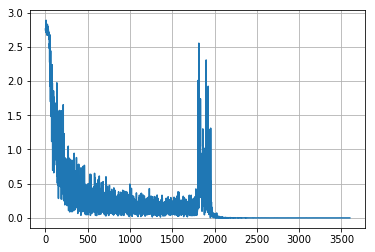

In [29]:
import matplotlib.pyplot as plt

plt.plot(LOSSES)
plt.grid()
plt.show()

## Save model

In [30]:
import datetime
now = datetime.datetime.now().strftime('%Y%m%d_%Hh%M')
now

'20180711_23h09'

In [31]:
torch.save(mynet.state_dict,'FishNet_'+now+'.pth')
#torch.save(mynet,'FishNet_'+now+'.pth')

/anaconda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FishNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Load model

In [22]:
models_path = glob.glob('*.pth')
models_path.sort()
models_path

['FishNet_20180705_21h41.pth',
 'FishNet_20180705_22h31.pth',
 'FishNet_20180706_07h25.pth',
 'FishNet_20180706_07h36.pth',
 'FishNet_20180709_08h16.pth',
 'FishNet_20180711_14h03.pth',
 'FishNet_20180711_14h10.pth',
 'FishNet_20180711_14h18.pth',
 'FishNet_20180711_15h52.pth',
 'FishNet_20180711_18h04.pth']

In [23]:
latest_model = models_path[-1]
mynet.load_state_dict(torch.load(latest_model)())
#mynet.state_dict()
latest_model

'FishNet_20180711_18h04.pth'

## Test step

In [32]:
errors = 0
mynet.eval()

for i, data in enumerate(testset):
    inputs, labels = data
    inputs, labels = Variable(inputs), Variable(labels)
    outputs = mynet(inputs)
    _,y = torch.max(outputs,1)
    errors += (y!=labels).sum().item()
    
accuracy = 1-errors/len(test_ids)  # Previously len(testset which was wrong because it gave the number of batches)
print('{:0.2f}% accuracy on the test set'.format(100*accuracy))

80.33% accuracy on the test set


No clown fish


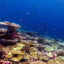

In [33]:
print(RESULT[y[0].item()])
transforms.ToPILImage()(inputs[0].data)